# Разведочный анализ данных и разметка

### Шаг 0: Подготовка
1. Поскольку коммерческие данные получить быстро не удалось, было принято решение использовать публичные данные, доступные на [госзакупках](https://zakupki.gov.ru/epz/main/public/home.html).
2. В связи с таким изменением подхода появилась необходимость переформулирования задачи, теперь она сформулирована так: "Классификация договора в зависимости от предмета по второму уровню ОКПД2". Классификатор ОКПД2 можно получить, например, [здесь](https://www.consultant.ru/document/cons_doc_LAW_163703/). Таким образом, цель изменилась до: по разделу предмета договора вернуть второй уровень кода ОКПД2.
Важное замечание: поскольку предметов договора в данном случае может быть много, то мы имеем дело с многоклассовой классификацией.
3. Датасет состоит из 199913 записей в формате JSON, содержащие три поля "regNum" - реестровый номер контракта, "contractSubjectFull" - полный текст предмета договора, "OKPD2_codes" - набор ОКПД2 кодов из договора. Датасет расположени по [адресу](https://www.kaggle.com/datasets/aldarovalexander/contract). Сам датасет был получен путем парсинга части исполненных договоров за 2022 год, которые бы имели формат верный DOCX и разбора формализованной части договоров. Часть процесса получения, например, из графического представления договора верного текста предмета в данном исследовании опущена, поскольку для целей самого исследования не представляет интереса.
4. Блокнот доступен в [колабе](https://colab.research.google.com/github/aldarovav/YearProject/blob/main/analysis.ipynb)


### Шаг 1: Импорт библиотек и настройка

In [1]:
!pip install pymorphy3
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import io
import requests
import json
import kagglehub
import pymorphy3
import nltk
import matplotlib.pyplot as plt

from io import StringIO
from collections import Counter

# Настройка отображения
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки загружены")
print("Текущая рабочая директория:", os.getcwd())

Библиотеки загружены
Текущая рабочая директория: /content


### Шаг 2: Загрузка и первичный анализ данных

In [3]:
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Указываем конкретный файл для загрузки
file_path = "contracts_dataset_unique.json"

# Сначала получим путь к файлу
dataset_path = kagglehub.dataset_download("aldarovalexander/contract")
full_file_path = f"{dataset_path}/{file_path}"

# Загрузим JSON с указанием dtype - это необходимо, поскольку иначе read_json воспринимает regNum как число и обрезает его, что создает неуникальные записи
df = pd.read_json(full_file_path, dtype={'regNum': str})


Using Colab cache for faster access to the 'contract' dataset.


In [4]:

# Посмотрим первые записи
print("Первые 5 записей:", df.head(5))

Первые 5 записей:                 regNum  \
0  0166300031414000004   
1  0324300007314000014   
2  0366300032914000027   
3  1010501417722000033   
4  1010501746721000017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [5]:
# Первичный анализ
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print("\nТипы данных:")
print(df.dtypes)


Размер датасета: (199913, 3)
Колонки: ['regNum', 'contractSubjectFull', 'OKPD2_codes']

Типы данных:
regNum                 object
contractSubjectFull    object
OKPD2_codes            object
dtype: object


In [6]:
# Более детальный анализ
print(f"Общее количество записей: {len(df)}")
print(f"Количество уникальных номеров контрактов: {df['regNum'].nunique()}")
print(f"Неуникальные номера контрактов: {df[df.duplicated('regNum', keep=False)]}")


Общее количество записей: 199913
Количество уникальных номеров контрактов: 199913
Неуникальные номера контрактов: Empty DataFrame
Columns: [regNum, contractSubjectFull, OKPD2_codes]
Index: []


Очень хороший результат - все записи уникальны

In [7]:
# Правильный анализ ОКПД кодов (списков)
all_okpd2_codes = df['OKPD2_codes'].explode() # Развернем списки ОКПД2 кодов для анализа
print(f"Всего ОКПД2 кодов (с повторениями): {len(all_okpd2_codes)}")
print(f"Уникальных ОКПД2 кодов: {all_okpd2_codes.nunique()}")
top_10_okpd2 = all_okpd2_codes.value_counts().head(10)
print(f"Топ-10 самых частых ОКПД2 кодов: {top_10_okpd2}")


Всего ОКПД2 кодов (с повторениями): 211887
Уникальных ОКПД2 кодов: 84
Топ-10 самых частых ОКПД2 кодов: OKPD2_codes
21    36805
10    28412
32    21144
26    10968
20     7493
01     7327
43     6795
17     6455
22     6036
68     4521
Name: count, dtype: int64


In [8]:

# Анализ структуры попадания кодов ОКПД2 в договоры
okpd2_counts = df['OKPD2_codes'].str.len()
print(f"Количество контрактов с одним OKPD2 кодом: {(okpd2_counts == 1).sum()}")
print(f"Количество контрактов с несколькими OKPD2 кодами: {(okpd2_counts > 1).sum()}")
print(f"Максимальное количество OKPD2 кодов в одном контракте: {okpd2_counts.max()}")


Количество контрактов с одним OKPD2 кодом: 191144
Количество контрактов с несколькими OKPD2 кодами: 8769
Максимальное количество OKPD2 кодов в одном контракте: 11


In [9]:
# Анализ текстовых данных
print(f"Средняя длина contractSubjectFull: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Максимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().max()} символов")
print(f"Минимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().min()} символов")

min_length = df['contractSubjectFull'].str.len().min()
min_length_samples = df[df['contractSubjectFull'].str.len() == min_length].head(10)

print(f"\n10 примеров с минимальной длиной ({min_length} символов):")
for i, row in min_length_samples.iterrows():
    print(f"{i+1}. regNum: {row['regNum']}")
    print(f"   contractSubjectFull: '{row['contractSubjectFull']}'")
    print()

Средняя длина contractSubjectFull: 872 символов
Максимальная длина contractSubjectFull: 9398 символов
Минимальная длина contractSubjectFull: 1 символов

10 примеров с минимальной длиной (1 символов):
6408. regNum: 1526001988422000024
   contractSubjectFull: '.'

6409. regNum: 1526001988422000026
   contractSubjectFull: '.'

6410. regNum: 1526001988422000061
   contractSubjectFull: '.'

6411. regNum: 1526001988422000087
   contractSubjectFull: '.'

6412. regNum: 1526001988422000091
   contractSubjectFull: '.'

6413. regNum: 1526001988422000113
   contractSubjectFull: '.'

24720. regNum: 2121501971922000035
   contractSubjectFull: '\'

42737. regNum: 2234000693422000300
   contractSubjectFull: ','

63980. regNum: 2390603079322000990
   contractSubjectFull: ','

64184. regNum: 2390603735822000174
   contractSubjectFull: ','



Очевидно, что есть некоторые проблемы с заполнением предмета договора. Есть основание считать, что менее 100 символов являются ошибками реализации выборки, проверим эту гипотезу

In [10]:
# Выбор всех записей с длиной contractSubjectFull менее 100 символов
short_texts = df[df['contractSubjectFull'].str.len() < 100]

print(f"Найдено записей с длиной текста менее 100символов: {len(short_texts)}")
print(f"Это составляет {len(short_texts) / len(df) * 100:.1f}% от общего количества записей")

# Вывод всех найденных записей
print("\nВсе записи с длиной contractSubjectFull < 100 символов:")
for i, (index, row) in enumerate(short_texts.iterrows(), 1):
    print(f"{i}. Длина: {len(row['contractSubjectFull'])} символов")
    print(f"   Текст: '{row['contractSubjectFull']}'")
    
    # Если есть другие столбцы, выводим их тоже
    other_columns = [col for col in df.columns if col != 'contractSubjectFull']
    for col in other_columns:
        print(f"   {col}: {row[col]}")
    print("-" * 50)

Найдено записей с длиной текста менее 100символов: 2253
Это составляет 1.1% от общего количества записей

Все записи с длиной contractSubjectFull < 100 символов:
1. Длина: 37 символов
   Текст: '1.1. «Заказчик» получает и оплачивает'
   regNum: 1010506281522000044
   OKPD2_codes: ['62']
--------------------------------------------------
2. Длина: 92 символов
   Текст: 'Государственный контракт на оказание услуги по разработке проектно-сметной документации на \'
   regNum: 1301501552722000152
   OKPD2_codes: ['71']
--------------------------------------------------
3. Длина: 73 символов
   Текст: '1.1. Поставщик обязуется поставить лампы светодиодные для нужд ФГБОУ ВО \'
   regNum: 1323401645022000077
   OKPD2_codes: ['27']
--------------------------------------------------
4. Длина: 97 символов
   Текст: '1.1. Поставщик обязуется передать в собственность продукты питания (овощи свежие) для нужд ФКУЗ \'
   regNum: 1231902322121000271
   OKPD2_codes: ['01']
------------------------------

Действительно обрезанные записи, считаем их ошибочными и удалим из датасета

In [11]:
# Находим индексы записей для удаления
indices_to_drop = df[df['contractSubjectFull'].str.len() < 100].index

# Удаляем записи
df = df.drop(indices_to_drop)

print(f"Удалено {len(indices_to_drop)} записей")
print(f"Осталось {len(df)} записей")

Удалено 2253 записей
Осталось 197660 записей


In [12]:
# Проверим что идентификатор договора везде заполнен верно
print("\n=== СТАТИСТИКА ПО КОЛОНКАМ ===")
print("Длина regNum:")
print(f"  Минимальная: {df['regNum'].str.len().min()}")
print(f"  Максимальная: {df['regNum'].str.len().max()}")
print(f"  Уникальные длины: {sorted(df['regNum'].str.len().unique())}")



=== СТАТИСТИКА ПО КОЛОНКАМ ===
Длина regNum:
  Минимальная: 19
  Максимальная: 19
  Уникальные длины: [np.int64(19)]


In [13]:
# Анализ распределения количества кодов на контракт

count_distribution = okpd2_counts.value_counts().sort_index()
for count, freq in count_distribution.items():
    print(f"  {count} код(ов): {freq} контрактов ({freq/len(df)*100:.1f}%)")

  1 код(ов): 191144 контрактов (96.7%)
  2 код(ов): 6674 контрактов (3.4%)
  3 код(ов): 1354 контрактов (0.7%)
  4 код(ов): 514 контрактов (0.3%)
  5 код(ов): 142 контрактов (0.1%)
  6 код(ов): 52 контрактов (0.0%)
  7 код(ов): 22 контрактов (0.0%)
  8 код(ов): 4 контрактов (0.0%)
  9 код(ов): 4 контрактов (0.0%)
  11 код(ов): 3 контрактов (0.0%)


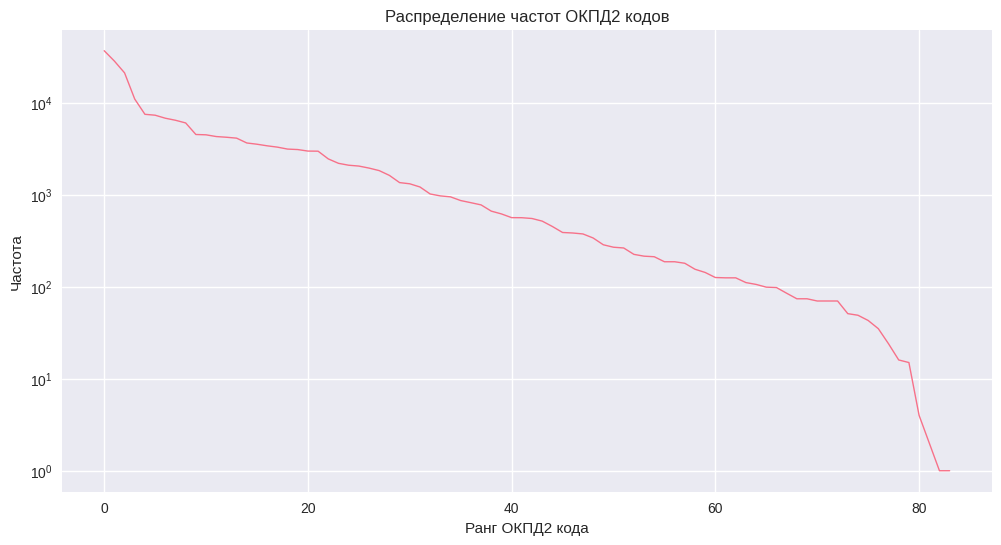

In [14]:
# Строим график распределения частот
all_okpd2_freq = all_okpd2_codes.value_counts()  # Это сет с частотами для каждого уникального кода
plt.figure(figsize=(12, 6))
plt.plot(range(len(all_okpd2_freq)), all_okpd2_freq.values, linewidth=1)
plt.title('Распределение частот ОКПД2 кодов')
plt.xlabel('Ранг ОКПД2 кода')
plt.ylabel('Частота')
plt.grid(True)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.show()


In [15]:

# Дополнительный анализ распределения
print(f"Медианная частота: {all_okpd2_freq.median()}")
print(f"Средняя частота: {all_okpd2_freq.mean():.2f}")
print(f"Максимальная частота: {all_okpd2_freq.max()}")
print(f"Минимальная частота: {all_okpd2_freq.min()}")
print(f"Стандартное отклонение: {all_okpd2_freq.std():.2f}")


Медианная частота: 557.5
Средняя частота: 2522.46
Максимальная частота: 36805
Минимальная частота: 1
Стандартное отклонение: 5651.42


In [16]:

# Анализ долей
total_mentions = all_okpd2_freq.sum()
top_10_percent = int(len(all_okpd2_freq) * 0.1)
top_10_percent_share = all_okpd2_freq.head(top_10_percent).sum() / total_mentions * 100
top_20_percent_share = all_okpd2_freq.head(int(len(all_okpd2_freq) * 0.2)).sum() / total_mentions * 100

print(f"На 10% самых частых кодов приходится {top_10_percent_share:.1f}% всех упоминаний")
print(f"На 20% самых частых кодов приходится {top_20_percent_share:.1f}% всех упоминаний")


На 10% самых частых кодов приходится 59.2% всех упоминаний
На 20% самых частых кодов приходится 75.6% всех упоминаний


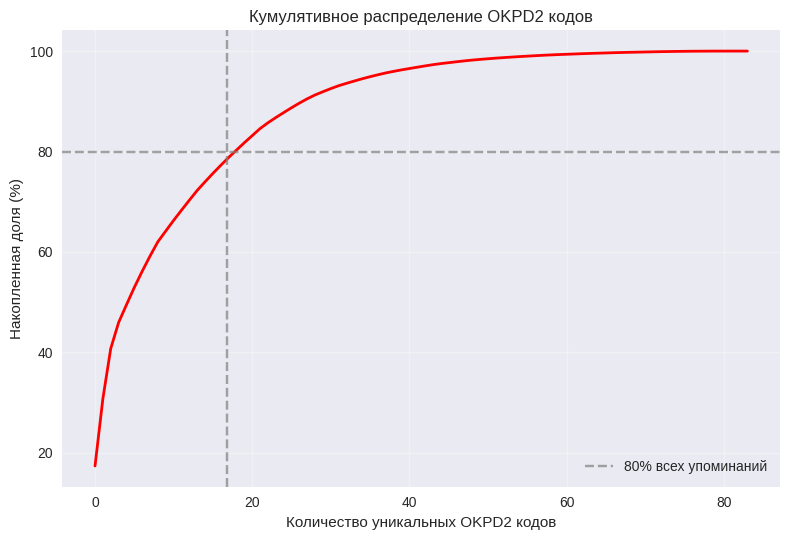

In [17]:

# Кумулятивное распределение
cumulative_share = all_okpd2_freq.cumsum() / total_mentions * 100
plt.plot(range(len(all_okpd2_freq)), cumulative_share, linewidth=2, color='red')
plt.title('Кумулятивное распределение OKPD2 кодов')
plt.xlabel('Количество уникальных OKPD2 кодов')
plt.ylabel('Накопленная доля (%)')
plt.grid(True, alpha=0.3)

# Добавляем ориентиры
plt.axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='80% всех упоминаний')
plt.axvline(x=len(all_okpd2_freq) * 0.2, color='gray', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


### Шаг 3: Предобработка текста

In [18]:
# Объединение текстовых полей
print("Длина текстов после очистки пропущенных значений:")
print(df['contractSubjectFull'].str.len().describe())

Длина текстов после очистки пропущенных значений:
count    197660.000000
mean        881.296585
std         650.372814
min         100.000000
25%         484.000000
50%         697.000000
75%        1054.000000
max        9398.000000
Name: contractSubjectFull, dtype: float64


In [19]:
from tqdm import tqdm

# Базовая очистка текста
import re
import pandas as pd

def clean_text(text):
    if pd.isna(text) or text == '':
        return ""

    text = text.lower()

    # Удаление приложений, ссылок, спецификаций
    text = re.sub(r'\(?(приложение|прил\.?|спецификаци[яией]|далее)\s*№?\s*\d*\)?', ' ', text, flags=re.IGNORECASE)

    # Удаление номеров контрактов и идентификаторов
    text = re.sub(r'(контракт|договор)\s*№?\s*\d+[/\-\\]\d+', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'идентификационный\s+код\s+закупки[:\-\s]*[\d\w]+', ' ', text, flags=re.IGNORECASE)

    # Удаление дат
    text = re.sub(r'\d{1,2}\s*[\.\/\\]\s*\d{1,2}\s*[\.\/\\]\s*\d{2,4}', ' ', text)
    text = re.sub(r'"\d{1,2}"\s*\w+\s*\d{4}\s*года?', ' ', text)

    # Удаление символа № и номеров
    text = re.sub(r'№\s*\d*', ' ', text)
    text = re.sub(r'\s№\s|^№\s|\s№$', ' ', text)

    # Удаление одиночных цифр (1-2 цифры, окружённые пробелами)
    text = re.sub(r'\s\d{1,2}\s', ' ', text)

    # Удаление очень коротких слов (опционально!)
    # text = re.sub(r'\s[а-яa-z]{1,2}\s', ' ', text)

    # Удаление всех символов кроме букв, цифр, пробелов, точек и дефисов (внутри слов)
    text = re.sub(r'[^a-zа-я0-9\s\.\-]', ' ', text)

    # Удаление множественных точек/запятых и нормализация пробелов
    text = re.sub(r'[\.,]{2,}', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Удаление всех оставшихся точек (если не нужны для сегментации)
    text = re.sub(r'\.', ' ', text)

    return text.strip()

# Применение функции с прогресс-баром
tqdm.pandas(desc="Очистка текста")
df['text_clean'] = df['contractSubjectFull'].progress_apply(clean_text)


Очистка текста: 100%|██████████| 197660/197660 [01:25<00:00, 2307.94it/s]


In [20]:
a = 550
print("Пример очистки текста:")
print("ДО:", df['contractSubjectFull'].iloc[a][:200])
print("ПОСЛЕ:", df['text_clean'].iloc[a][:200])

Пример очистки текста:
ДО: 1.1. Поставщик обязуется поставить термоклеевую машину (далее - Товар), а Заказчик обязуется принять и оплатить Товар в порядке и на условиях, предусмотренных Контрактом. 1.2. Наименование, количество
ПОСЛЕ: 1 1  поставщик обязуется поставить термоклеевую машину - товар а заказчик обязуется принять и оплатить товар в порядке и на условиях предусмотренных контрактом  1 2  наименование количество и иные хар


In [21]:
# Удаление стоп-слов
from nltk.corpus import stopwords

# Скачивание стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Доменные стоп-слова
domain_stopwords = [
    'контракт', 'договор', 'приложение', 'пункт', 'статья', 'далее', 
    'согласно', 'также', 'например', 'иной', 'другой', 'обязан', 
    'обязана', 'обязаны', 'обязано', 'условие', 'следующий', 'документ', 
    'соглашение', 'протокол', 'решение', 'акт', 'отчет', 'настоящий',
    'настоящего', 'настоящем', 'настоящему']

# Добавляем предлоги и союзы
prepositions = ['по', 'в', 'и', 'с', 'у', 'на', 'за', 'к', 'о', 'от', 'до', 'из', 'без']
conjunctions = ['а', 'но', 'или', 'то', 'как', 'что', 'чтобы', 'if', 'and', 'or']

custom_stopwords = set(russian_stopwords + domain_stopwords + prepositions + conjunctions)
print(custom_stopwords)

{'настоящем', 'его', 'ней', 'них', 'хорошо', 'ее', 'ну', 'протокол', 'не', 'за', 'в', 'том', 'кто', 'о', 'со', 'три', 'их', 'эти', 'он', 'у', 'вдруг', 'до', 'раз', 'бы', 'если', 'или', 'тот', 'настоящий', 'про', 'с', 'все', 'всех', 'наконец', 'еще', 'потому', 'два', 'соглашение', 'обязан', 'чем', 'какой', 'пункт', 'ему', 'себя', 'нет', 'обязано', 'после', 'им', 'статья', 'но', 'далее', 'более', 'куда', 'чуть', 'на', 'обязана', 'один', 'мой', 'нас', 'над', 'тут', 'больше', 'даже', 'можно', 'было', 'теперь', 'был', 'эту', 'if', 'акт', 'нельзя', 'никогда', 'к', 'для', 'уж', 'от', 'потом', 'ведь', 'and', 'перед', 'приложение', 'почти', 'другой', 'здесь', 'были', 'этом', 'опять', 'по', 'лучше', 'всегда', 'так', 'мы', 'решение', 'во', 'хоть', 'быть', 'этого', 'была', 'чтоб', 'обязаны', 'вот', 'тебя', 'нее', 'же', 'через', 'также', 'вас', 'настоящему', 'как', 'впрочем', 'настоящего', 'or', 'отчет', 'надо', 'сам', 'когда', 'согласно', 'там', 'есть', 'она', 'условие', 'ли', 'совсем', 'они', 'бу

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#Функция удаления стоп-слов
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in custom_stopwords]

In [23]:
# Создаем анализатор pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [24]:
#Функция лемматизации текста
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for token in tokens:
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmatized_tokens.append(lemma)
        except Exception:
            lemmatized_tokens.append(token)
    return lemmatized_tokens

In [25]:
#Функция токенизации текста 
def tokenize_text(text):
    return text.split()

In [26]:
# Функция основной обработки текста
def advanced_text_processing(text):
    # Проверка на непустоту
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Токенизация
    tokens = text.split()
    
    # Удаление стоп-слов (приводим к нижнему регистру для сравнения)
    tokens = [token for token in tokens if token.lower() not in custom_stopwords]
    
    # Лемматизация
    lemmatized_tokens = []
    for token in tokens:
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmatized_tokens.append(lemma)
        except Exception as e:
            lemmatized_tokens.append(token)
    
    # Удаление стоп-слов после лемматизации и токенизации
    tokens = [token for token in tokens if token.lower() not in custom_stopwords]

    return ' '.join(lemmatized_tokens)

In [27]:
#Тестирование нашей обработки на одном примере
test_text = df['contractSubjectFull'].iloc[1] if len(df) > 0 else "Пример текста для тестирования обработки"
print("Исходный текст:", test_text)
processed_text = advanced_text_processing(test_text)
print("\nРезультат:", processed_text)

Исходный текст: Исполнитель обязуется выполнить работу согласно Приложению № к Контракту и сдать ее результат Заказчику, а Заказчик обязуется принять результат работы и оплатить его. Качество работы Качество выполненной работы должно соответствовать требованиям, указанным в Приложении № к Контракту. Гарантийный срок, установленный на результат работы, указан в Приложении № к Контракту. Гарантийный срок исчисляется с момента, когда по условиям Контракта результат выполненной работы принят или должен быть принят Заказчиком. Гарантийный срок продлевается на период, в течение которого Заказчик не мог пользоваться результатом работы из-за обнаруженных в нем недостатков, при условии, что Исполнитель был письменно извещен Заказчиком об обнаружении недостатков в срок, предусмотренный Контрактом. Гарантия качества распространяется на все, что составляет результат работы. В случае предъявления Заказчиком требования о безвозмездном устранении недостатков выполненной работы согласно п. 1 ст. 723 Г

In [28]:
# Применяем ко всему датафрейму
print("Начата обработка всего датасета...")

# Упрощаем функцию для массовой обработки с отслеживанием прогресса
def advanced_text_processing_fast(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    tokens = text.split()
    tokens = [token for token in tokens if token.lower() not in custom_stopwords]
    
    lemmatized_tokens = []
    for token in tokens:
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmatized_tokens.append(lemma)
        except Exception:
            lemmatized_tokens.append(token)
    
    return ' '.join(lemmatized_tokens)

# Вариант 1: Простой прогресс-бар с tqdm
try:
    from tqdm import tqdm
    tqdm.pandas()
    
    print("Используется tqdm для отслеживания прогресса...")
    df['text_processed'] = df['contractSubjectFull'].progress_apply(advanced_text_processing_fast)
    
except ImportError:
    # Вариант 2: Ручной отсчет прогресса
    print("tqdm не установлен, используем ручной отсчет...")
    
    def apply_with_progress(series, func):
        results = []
        total = len(series)
        for i, item in enumerate(series):
            results.append(func(item))
            if (i + 1) % 100 == 0 or (i + 1) == total:
                print(f"Обработано: {i + 1}/{total} ({((i + 1) / total) * 100:.1f}%)")
        return results
    
    df['text_processed'] = apply_with_progress(df['contractSubjectFull'], advanced_text_processing_fast)

print("Обработка завершена!")

Начата обработка всего датасета...
Используется tqdm для отслеживания прогресса...


100%|██████████| 197660/197660 [39:10<00:00, 84.10it/s]  


Обработка завершена!


In [29]:
# Статистика обработки
print(f"Общее количество записей: {len(df)}")
print(f"Средняя длина исходного текста: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Средняя длина обработанного текста: {df['text_processed'].str.len().mean():.0f} символов")
print(f"Сжатие текста: {(1 - df['text_processed'].str.len().mean() / df['contractSubjectFull'].str.len().mean()) * 100:.1f}%")

Общее количество записей: 197660
Средняя длина исходного текста: 881 символов
Средняя длина обработанного текста: 791 символов
Сжатие текста: 10.3%


In [30]:
# Показываем примеры обработки
for i in range(min(5, len(df))):
    print(f"\nПример {i+1}:")
    original = df['contractSubjectFull'].iloc[i]
    processed = df['text_processed'].iloc[i]
    
    print("ДО:", original[:150] + "..." if len(original) > 150 else original)
    print("ПОСЛЕ:", processed[:150] + "..." if len(processed) > 150 else processed)
    print("-" * 80)


Пример 1:
ДО: 1.1. Подрядчик обязуется выполнить работы по ремонту кровли и утеплению труб жилого дома №6, расположенного по адресу: Тульская область, Ленинский рай...
ПОСЛЕ: 1.1. подрядчик обязываться выполнить работа ремонт кровля утепление труба жилой дом №6, расположить адресу: тульский область, ленинский район, п. моло...
--------------------------------------------------------------------------------

Пример 2:
ДО: Исполнитель обязуется выполнить работу согласно Приложению № к Контракту и сдать ее результат Заказчику, а Заказчик обязуется принять результат работы...
ПОСЛЕ: исполнитель обязываться выполнить работа приложение № контракт сдать результат заказчику, заказчик обязываться принять результат работа оплатить его. ...
--------------------------------------------------------------------------------

Пример 3:
ДО: 1.1. По настоящему контракту поставщик обязуется поставить и передать заказчику в срок, предусмотренный настоящим контрактом, лекарственные препараты ...
ПОСЛЕ: 1.

In [31]:
# Анализ эффективности обработки
empty_processed = df['text_processed'].str.strip().eq('').sum()
print(f"Пустых текстов после обработки: {empty_processed}")
print(f"Уникальных обработанных текстов: {df['text_processed'].nunique()}")

# Топ-10 самых частых слов после обработки
from collections import Counter
all_words = ' '.join(df['text_processed'].dropna()).split()
word_freq = Counter(all_words)
print(f"\nТоп-10 самых частых слов после обработки:")
for word, freq in word_freq.most_common(10):
    print(f"  {word}: {freq}")

Пустых текстов после обработки: 0
Уникальных обработанных текстов: 152209

Топ-10 самых частых слов после обработки:
  товар: 419617
  (приложение: 394441
  обязываться: 340901
  заказчик: 334680
  №: 281243
  технический: 275768
  поставщик: 239157
  (далее: 235720
  контракт: 229187
  соответствие: 221148


Топ-10 самых частых слов после обработки:
  обязуется: 340701
  №: 281243
  (далее: 235462
  соответствии: 215894
  (Приложение: 205405
  1: 202434
  -: 198649
  Товара: 190669
  Поставщик: 183092
  (приложение: 178492

Такое распределение указывает на то, что можно подрезать скобки, знаки номеров, слова: обязуется, далее, приложение

### Шаг 4: Разметка данных

In [32]:
print(f"Всего записей: {len(df)}")
print(f"Записей с OKPD2: {df['OKPD2_codes'].notna().sum()}")
print(f"Процент размеченных данных: {df['OKPD2_codes'].notna().mean():.2%}")

# Анализ структуры OKPD2 кодов
df['okpd_count'] = df['OKPD2_codes'].apply(lambda x: len(x) if x else 0)
print("\nРаспределение количества кодов OKPD2 на запись:")
print(df['okpd_count'].value_counts().sort_index())

Всего записей: 197660
Записей с OKPD2: 197660
Процент размеченных данных: 100.00%

Распределение количества кодов OKPD2 на запись:
okpd_count
1     189232
2       6360
3       1334
4        508
5        141
6         52
7         22
8          4
9          4
11         3
Name: count, dtype: int64


In [36]:
# Извлечение и нормализация целевых меток
def extract_okpd_labels(okpd_codes):
    """Извлекает все коды ОКПД2 для классификации"""
    if not okpd_codes or len(okpd_codes) == 0:
        return []
    
    # Извлекаем все коды и нормализуем их до 2-значного уровня
    normalized_codes = []
    for code in okpd_codes:
        if len(code) >= 2:
            normalized_codes.append(code[:2])  # Первые 2 цифры - раздел
        else:
            normalized_codes.append(code)
    
    return normalized_codes

# Создание бинарной матрицы для мульти-лейбл классификации
from sklearn.preprocessing import MultiLabelBinarizer

# Создаем целевую переменную - список всех кодов ОКПД2
df['target'] = df['OKPD2_codes'].apply(extract_okpd_labels)

print("Распределение количества меток на запись:")
print(df['target'].apply(len).value_counts().sort_index())

print("\nОбщая статистика по меткам:")
print(f"Всего записей: {len(df)}")
print(f"Записей без меток: {df['target'].apply(len).eq(0).sum()}")

# Анализ меток
all_labels = [label for sublist in df['target'] for label in sublist]
print(f"Всего меток (с повторениями): {len(all_labels)}")

print("\nУровень детализации меток:")
label_lengths = pd.Series([len(label) for label in all_labels])
print(label_lengths.value_counts().sort_index())

print("\nТоп-10 самых частых меток ОКПД2:")
from collections import Counter
label_counts = Counter(all_labels)
for label, count in label_counts.most_common(10):
    print(f"{label}: {count} раз")

print(f"\nВсего уникальных меток: {len(label_counts)}")

# Получаем все уникальные метки (теперь столбец 'target' существует)
all_labels = [label for sublist in df['target'] for label in sublist]
unique_labels = sorted(set(all_labels))

print(f"Уникальные метки для классификации: {unique_labels}")

# Создаем бинарную матрицу
mlb = MultiLabelBinarizer(classes=unique_labels)
target_matrix = mlb.fit_transform(df['target'])

# Создаем DataFrame с бинарными метками
target_df = pd.DataFrame(target_matrix, columns=mlb.classes_, index=df.index)

print(f"\nСоздано {len(unique_labels)} уникальных меток ОКПД2")
print(f"Размер матрицы целевых переменных: {target_matrix.shape}")
print(f"Пример бинарных меток для первых 5 записей:")
print(target_df.head())

Распределение количества меток на запись:
target
1     189232
2       6360
3       1334
4        508
5        141
6         52
7         22
8          4
9          4
11         3
Name: count, dtype: int64

Общая статистика по меткам:
Всего записей: 197660
Записей без меток: 0
Всего меток (с повторениями): 209258

Уровень детализации меток:
2    209258
Name: count, dtype: int64

Топ-10 самых частых меток ОКПД2:
21: 36692 раз
10: 28318 раз
32: 20954 раз
26: 10847 раз
20: 7399 раз
01: 7289 раз
43: 6655 раз
17: 6392 раз
22: 5960 раз
68: 4507 раз

Всего уникальных меток: 84
Уникальные метки для классификации: ['01', '02', '03', '05', '06', '08', '09', '10', '11', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '35', '36', '37', '38', '39', '41', '42', '43', '45', '46', '47', '49', '50', '51', '52', '53', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '75

In [ ]:
# Анализ качества разметки для мульти-лейбл классификации
# Смотрим примеры текстов для самых частых классов

# Получаем самые частые отдельные метки (не списки)
top_labels = label_counts.most_common(5)
sample_labels = [label for label, count in top_labels]

for class_label in sample_labels:
    # Ищем записи, которые содержат данную метку
    mask = df['target'].apply(lambda x: class_label in x)
    class_texts = df[mask]['text_clean'].head(2)
    
    print(f"\n--- Метка {class_label} ({mask.sum()} примеров) ---")
    for i, text in enumerate(class_texts):
        print(f"{i+1}. {text[:150]}...")
    print(f"Все метки для этой категории: {df[mask]['target'].iloc[0] if len(df[mask]) > 0 else 'нет примеров'}")

=== АНАЛИЗ КАЧЕСТВА РАЗМЕТКИ ===

--- Метка 21 (36692 примеров) ---
1. 1 1  по настоящему контракту поставщик обязуется поставить и передать заказчику в срок предусмотренный настоящим контрактом лекарственные препараты - ...
2. в соответствии с контрактом поставщик обязуется в порядке и сроки предусмотренные контрактом осуществить поставку лекарственных препаратов для медицин...
Все метки для этой категории: ['21']

--- Метка 10 (28318 примеров) ---
1. объект закупки 1 1  поставщик обязуется передать грузополучателю государственного заказчика молоко ультрапастеризованное в рамках государственного обо...
2. 1 1  поставщик обязуется передать в собственность продукты питания бакалея - товар заказчику в обусловленный настоящим контрактом срок согласно n к на...
Все метки для этой категории: ['10']

--- Метка 32 (20954 примеров) ---
1. 1 1  поставщик обязуется поставить медицинские расходные материалы шприцы иглы товар в соответствии со й к контракту а заказчик обязуется принять и оп...
2. 

In [40]:
# Обработка проблем разметки для мульти-лейбл классификации

# 1. Анализ записей без меток (пустые списки)
empty_targets = df['target'].apply(len) == 0
print(f"Записей без меток (пустые списки): {empty_targets.sum()}")

# 2. Анализ малочисленных отдельных меток
# Собираем статистику по всем отдельным меткам
all_labels = [label for sublist in df['target'] for label in sublist]
label_counts = Counter(all_labels)

# Находим малочисленные метки (менее 5 примеров)
small_labels = {label: count for label, count in label_counts.items() if count < 5}
print(f"Малочисленные отдельные метки (менее 5 примеров): {len(small_labels)}")

# 3. Анализ записей с редкими метками
records_with_small_labels = df['target'].apply(
    lambda labels: any(label in small_labels for label in labels)
).sum()
print(f"Записей, содержащих хотя бы одну малочисленную метку: {records_with_small_labels}")

# 4. Решение: несколько стратегий
print("\n=== СТРАТЕГИИ ОБРАБОТКИ ===")

# Стратегия 1: Удаление записей без меток
df_clean = df[~empty_targets].copy()
print(f"После удаления пустых меток: {len(df_clean)} записей")

# Стратегия 2: Удаление малочисленных меток из списков
def remove_small_labels(labels, small_labels_set):
    """Удаляет малочисленные метки из списка"""
    return [label for label in labels if label not in small_labels_set]

small_labels_set = set(small_labels.keys())
df_clean['target_clean'] = df_clean['target'].apply(
    lambda x: remove_small_labels(x, small_labels_set)
)

# Проверяем, не остались ли записи без меток после очистки
empty_after_clean = df_clean['target_clean'].apply(len) == 0
print(f"Записей без меток после очистки: {empty_after_clean.sum()}")

# Удаляем записи, которые остались без меток после очистки
df_final = df_clean[~empty_after_clean].copy()

print(f"Итоговый размер датасета: {len(df_final)} записей")

# Анализ результатов очистки
all_labels_final = [label for sublist in df_final['target_clean'] for label in sublist]
label_counts_final = Counter(all_labels_final)

print(f"Уникальных меток после очистки: {len(label_counts_final)}")
print(f"Минимальное количество примеров на метку: {min(label_counts_final.values())}")
print(f"Максимальное количество примеров на метку: {max(label_counts_final.values())}")

# Статистика по количеству меток на запись после очистки
labels_per_record_final = df_final['target_clean'].apply(len)
print(f"\nРаспределение количества меток на запись после очистки:")
print(labels_per_record_final.value_counts().sort_index())

Записей без меток (пустые списки): 0
Малочисленные отдельные метки (менее 5 примеров): 4
Записей, содержащих хотя бы одну малочисленную метку: 8

=== СТРАТЕГИИ ОБРАБОТКИ ===
После удаления пустых меток: 197660 записей
Записей без меток после очистки: 7
Итоговый размер датасета: 197653 записей
Уникальных меток после очистки: 80
Минимальное количество примеров на метку: 15
Максимальное количество примеров на метку: 36692

Распределение количества меток на запись после очистки:
target_clean
1     189225
2       6360
3       1334
4        509
5        140
6         52
7         22
8          4
9          4
11         3
Name: count, dtype: int64


In [ ]:
# Валидация разметки
sample_indices = random.sample(range(len(df_labeled)), 5)

for idx in sample_indices:
    row = df_labeled.iloc[idx]
    print(f"\nМетка: {row['target']}")
    print(f"Текст: {row['text_clean'][:200]}...")
    print("-" * 50)

=== ДЕТАЛЬНАЯ ВАЛИДАЦИЯ РАЗМЕТКИ ===


NameError: name 'df_valid' is not defined

### Шаг 5: Анализ размеченных данных

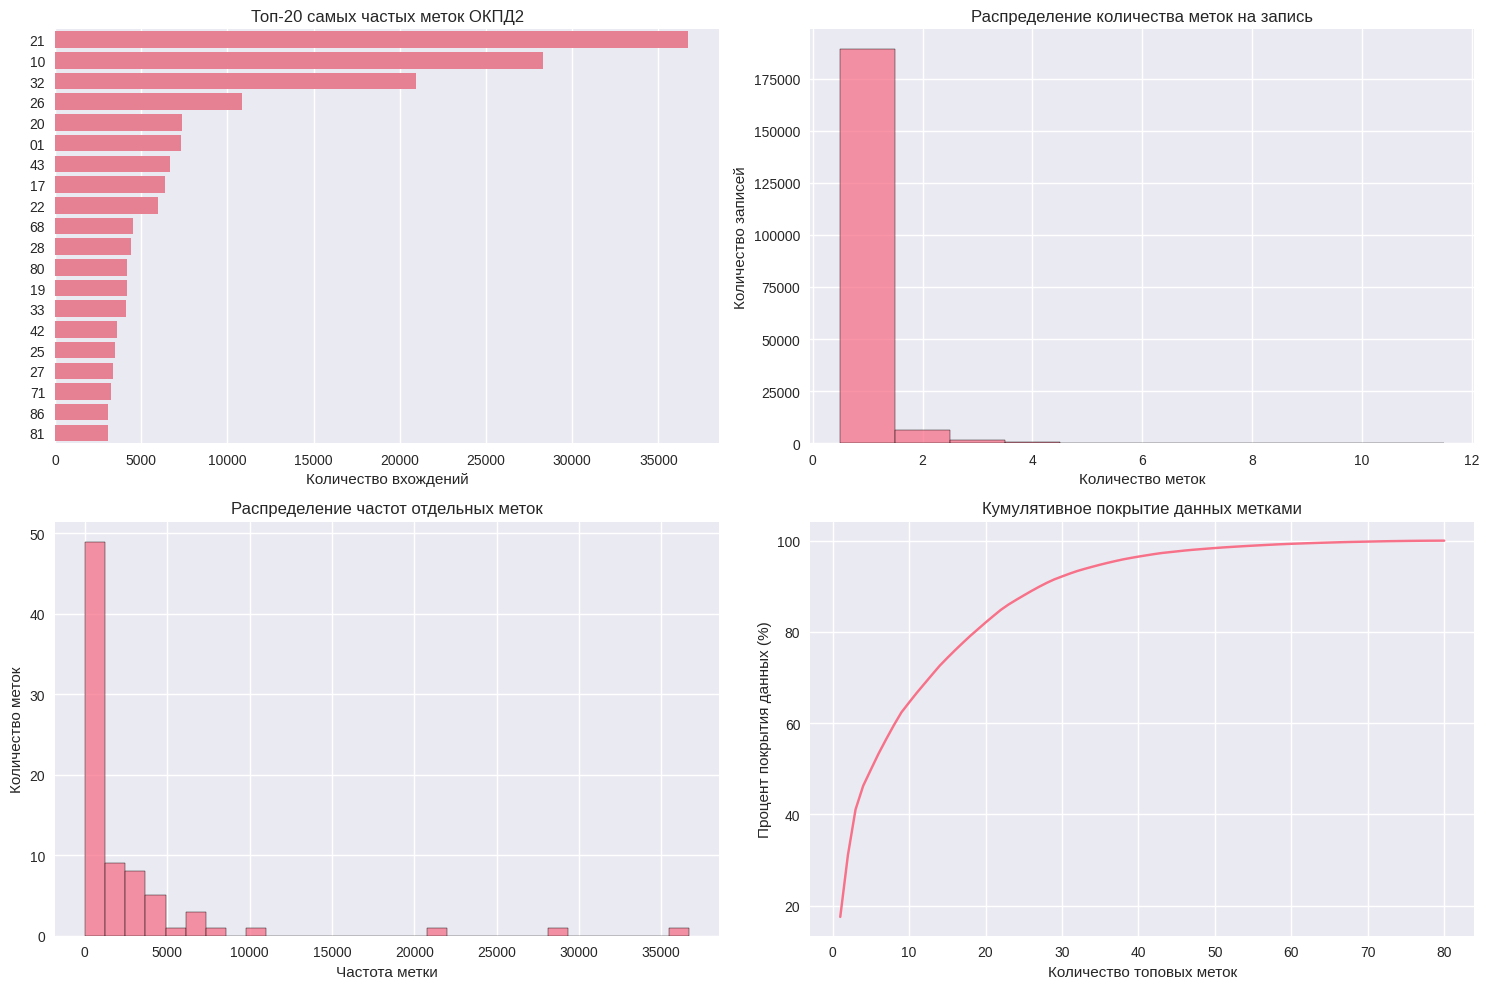

=== СТАТИСТИКА МУЛЬТИ-ЛЕЙБЛ ДАННЫХ ===
Всего записей: 197660
Всего уникальных меток: 80
Общее количество вхождений меток: 209250

Распределение количества меток на запись:
  1 меток: 189232 записей (95.7%)
  2 меток: 6360 записей (3.2%)
  3 меток: 1334 записей (0.7%)
  4 меток: 508 записей (0.3%)
  5 меток: 141 записей (0.1%)
  6 меток: 52 записей (0.0%)
  7 меток: 22 записей (0.0%)
  8 меток: 4 записей (0.0%)
  9 меток: 4 записей (0.0%)
  11 меток: 3 записей (0.0%)

Статистика по отдельным меткам:
Медианная частота метки: 586.5
Минимальная частота: 15
Максимальная частота: 36692
Средняя частота: 2615.6

Анализ покрытия меток:
Топ-5 меток покрывают 49.8% данных
Топ-10 меток покрывают 64.5% данных
Топ-20 меток покрывают 82.0% данных
Топ-50 меток покрывают 98.4% данных


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Статистика для мульти-лейбл классификации
plt.figure(figsize=(15, 10))

# 1. Топ-20 самых частых отдельных меток
plt.subplot(2, 2, 1)
top_labels = label_counts_final.most_common(20)
labels, counts = zip(*top_labels)
sns.barplot(x=list(counts), y=list(labels))
plt.title('Топ-20 самых частых меток ОКПД2')
plt.xlabel('Количество вхождений')

# 2. Распределение количества меток на запись
plt.subplot(2, 2, 2)
labels_per_record = df['target'].apply(len)
sns.histplot(labels_per_record, bins=30, discrete=True)
plt.title('Распределение количества меток на запись')
plt.xlabel('Количество меток')
plt.ylabel('Количество записей')

# 3. Распределение размеров классов (отдельных меток)
plt.subplot(2, 2, 3)
class_sizes = list(label_counts_final.values())
sns.histplot(class_sizes, bins=30)
plt.title('Распределение частот отдельных меток')
plt.xlabel('Частота метки')
plt.ylabel('Количество меток')

# 4. Кумулятивное покрытие данных
plt.subplot(2, 2, 4)
cumulative_counts = []
current_sum = 0
for count in sorted(class_sizes, reverse=True):
    current_sum += count
    cumulative_counts.append(current_sum)

total_labels = sum(class_sizes)
cumulative_percentage = [x / total_labels * 100 for x in cumulative_counts]

plt.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage)
plt.title('Кумулятивное покрытие данных метками')
plt.xlabel('Количество топовых меток')
plt.ylabel('Процент покрытия данных (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Статистика по мульти-лейбл данным
print("=== СТАТИСТИКА МУЛЬТИ-ЛЕЙБЛ ДАННЫХ ===")
print(f"Всего записей: {len(df)}")
print(f"Всего уникальных меток: {len(label_counts_final)}")
print(f"Общее количество вхождений меток: {sum(label_counts_final.values())}")

print(f"\nРаспределение количества меток на запись:")
labels_count_stats = labels_per_record.value_counts().sort_index()
for count, freq in labels_count_stats.items():
    percentage = freq / len(df) * 100
    print(f"  {count} меток: {freq} записей ({percentage:.1f}%)")

print(f"\nСтатистика по отдельным меткам:")
print(f"Медианная частота метки: {pd.Series(class_sizes).median()}")
print(f"Минимальная частота: {min(class_sizes)}")
print(f"Максимальная частота: {max(class_sizes)}")
print(f"Средняя частота: {pd.Series(class_sizes).mean():.1f}")

# Анализ покрытия
print(f"\nАнализ покрытия меток:")
top_n = [5, 10, 20, 50]
for n in top_n:
    if n <= len(label_counts_final):
        coverage = sum([count for _, count in label_counts_final.most_common(n)]) / sum(label_counts_final.values()) * 100
        print(f"Топ-{n} меток покрывают {coverage:.1f}% данных")

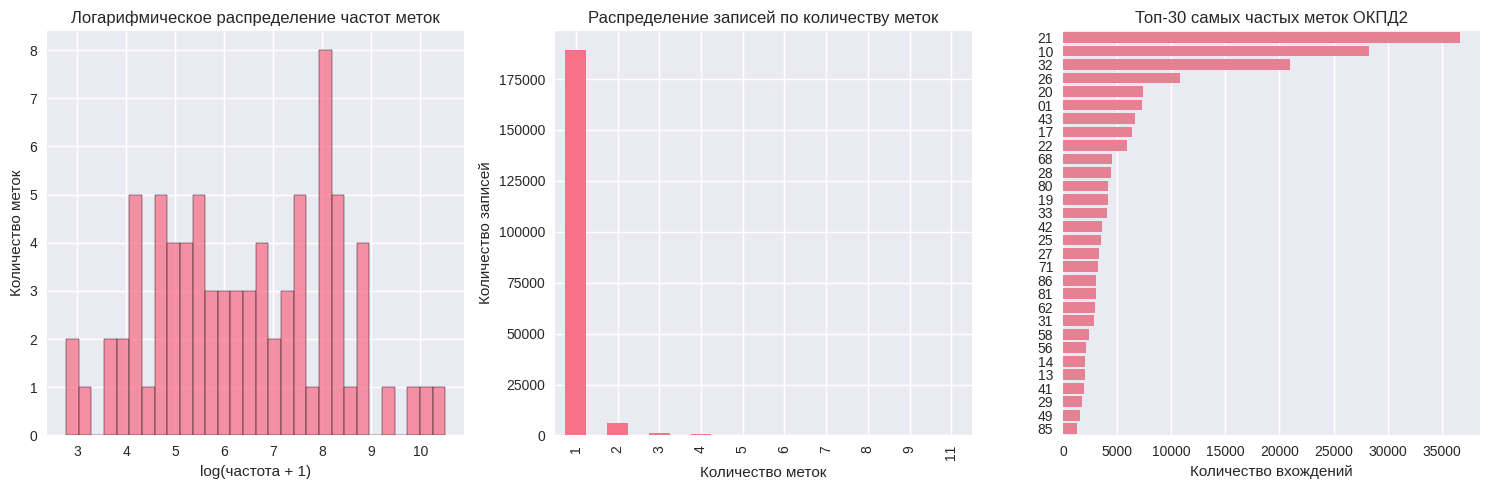


=== АНАЛИЗ КОМБИНАЦИЙ МЕТОК ===
Топ-10 самых частых комбинаций меток:
1. ['21']: 35948 записей (18.2%)
2. ['10']: 26149 записей (13.2%)
3. ['32']: 19122 записей (9.7%)
4. ['26']: 10143 записей (5.1%)
5. ['43']: 6465 записей (3.3%)
6. ['20']: 5261 записей (2.7%)
7. ['01']: 5167 записей (2.6%)
8. ['17']: 4887 записей (2.5%)
9. ['68']: 4498 записей (2.3%)
10. ['80']: 4164 записей (2.1%)

Коэффициент сбалансированности (min/max): 0.0004
Стандартное отклонение частот: 5738.2


In [47]:
# Дополнительный анализ сбалансированности
plt.figure(figsize=(15, 5))

# 1. Логарифмическое распределение частот меток
plt.subplot(1, 3, 1)
class_sizes_series = pd.Series(class_sizes)
sns.histplot(np.log1p(class_sizes_series), bins=30)
plt.title('Логарифмическое распределение частот меток')
plt.xlabel('log(частота + 1)')
plt.ylabel('Количество меток')

# 2. Количество меток vs количество записей
plt.subplot(1, 3, 2)
labels_per_record.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение записей по количеству меток')
plt.xlabel('Количество меток')
plt.ylabel('Количество записей')

# 3. Топ-30 меток (более детально)
plt.subplot(1, 3, 3)
top_30_labels = label_counts_final.most_common(30)
labels_30, counts_30 = zip(*top_30_labels)
sns.barplot(x=list(counts_30), y=list(labels_30))
plt.title('Топ-30 самых частых меток ОКПД2')
plt.xlabel('Количество вхождений')

plt.tight_layout()
plt.show()

# Анализ самых популярных комбинаций меток
print("\n=== АНАЛИЗ КОМБИНАЦИЙ МЕТОК ===")
from collections import Counter

# Анализируем комбинации меток (первые 2-3 самые частые)
label_combinations = df['target'].apply(tuple).value_counts().head(10)

print("Топ-10 самых частых комбинаций меток:")
for i, (combo, count) in enumerate(label_combinations.items(), 1):
    print(f"{i}. {list(combo)}: {count} записей ({count/len(df)*100:.1f}%)")

# Анализ сбалансированности
print(f"\nКоэффициент сбалансированности (min/max): {min(class_sizes)/max(class_sizes):.4f}")
print(f"Стандартное отклонение частот: {pd.Series(class_sizes).std():.1f}")

In [48]:
# Анализ для подготовки к ML
print("\n=== АНАЛИЗ ДЛЯ ПОДГОТОВКИ К ML ===")

# Рекомендации по обработке несбалансированности
imbalance_ratio = max(class_sizes) / min(class_sizes)
print(f"Коэффициент несбалансированности: {imbalance_ratio:.1f}")

if imbalance_ratio > 100:
    print("⚠️  Высокая несбалансированность - рекомендуется:")
    print("   - Использовать взвешенные функции потерь")
    print("   - Применить oversampling/undersampling")
    print("   - Использовать метрики, устойчивые к несбалансированности")
elif imbalance_ratio > 10:
    print("⚠️  Умеренная несбалансированность - рекомендуется:")
    print("   - Взвешенные функции потерь")
    print("   - Стратифицированная выборка")
else:
    print("✓  Данные достаточно сбалансированы")

# Анализ мульти-лейбл характеристик
avg_labels_per_record = labels_per_record.mean()
print(f"\nСреднее количество меток на запись: {avg_labels_per_record:.2f}")

if avg_labels_per_record > 3:
    print("⚠️  Высокая мульти-лейблность - рекомендуется:")
    print("   - Binary Relevance подход")
    print("   - Метрики: precision@k, coverage")
elif avg_labels_per_record > 1.5:
    print("✓  Умеренная мульти-лейблность - подходят:")
    print("   - Classifier Chains")
    print("   - Label Powerset")
else:
    print("✓  Низкая мульти-лейблность - можно использовать:")
    print("   - Любые мульти-лейбл методы")


=== АНАЛИЗ ДЛЯ ПОДГОТОВКИ К ML ===
Коэффициент несбалансированности: 2446.1
⚠️  Высокая несбалансированность - рекомендуется:
   - Использовать взвешенные функции потерь
   - Применить oversampling/undersampling
   - Использовать метрики, устойчивые к несбалансированности

Среднее количество меток на запись: 1.06
✓  Низкая мульти-лейблность - можно использовать:
   - Любые мульти-лейбл методы


### Шаг 6: Разделение на выборки

In [52]:
from sklearn.model_selection import train_test_split
import numpy as np

# Используем наш обработанный датасет
X = df['text_clean']  # или 'text_processed', если есть
y = df['target']  # список меток для каждой записи

# Для мульти-лейбл данных используем iterative_train_test_split из skmultilearn
# или создаем свою стратегию стратификации

print(f"Всего данных для разделения: {len(X)} записей")

# Способ 1: Простое случайное разделение (без стратификации)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("=== РАЗДЕЛЕНИЕ БЕЗ СТРАТИФИКАЦИИ ===")
print(f"Обучающая выборка: {len(X_train)} записей ({len(X_train)/len(X):.1%})")
print(f"Валидационная выборка: {len(X_val)} записей ({len(X_val)/len(X):.1%})")
print(f"Тестовая выборка: {len(X_test)} записей ({len(X_test)/len(X):.1%})")

Всего данных для разделения: 197660 записей
=== РАЗДЕЛЕНИЕ БЕЗ СТРАТИФИКАЦИИ ===
Обучающая выборка: 138362 записей (70.0%)
Валидационная выборка: 29649 записей (15.0%)
Тестовая выборка: 29649 записей (15.0%)


### Шаг 7: Векторизация текста

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF с разными настройками
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Учитываем отдельные слова и пары
    min_df=2,           # Игнорируем очень редкие слова
    max_df=0.9,         # Игнорируем очень частые слова
    stop_words=list(custom_stopwords)
)

# Bag-of-Words для сравнения
bow_vectorizer = CountVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words=list(custom_stopwords)
)

print("Векторизаторы созданы")

Векторизаторы созданы


In [54]:
# TF-IDF
print("Векторизация TF-IDF...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Bag-of-Words
print("Векторизация Bag-of-Words...")
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"\nРазмерности матриц признаков:")
print(f"TF-IDF: {X_train_tfidf.shape}")
print(f"BOW: {X_train_bow.shape}")

# Сохранение processed данных
df_processed = pd.DataFrame({
    'text_processed': X,
    'target': y
})
df_processed.to_csv('processed_contracts_data.csv', index=False)
print("\nОбработанные данные сохранены в 'processed_contracts_data.csv'")

Векторизация TF-IDF...
Векторизация Bag-of-Words...

Размерности матриц признаков:
TF-IDF: (138362, 10000)
BOW: (138362, 8000)

Обработанные данные сохранены в 'processed_contracts_data.csv'


In [55]:
# Анализ полученных признаков
def analyze_features(vectorizer, X_matrix, name):
    """Анализирует полученные признаки после векторизации"""
    print(f"\n=== АНАЛИЗ {name} ПРИЗНАКОВ ===")
    
    # Получаем частоты признаков
    feature_freq = np.array(X_matrix.sum(axis=0)).flatten()
    
    print(f"Общее количество признаков: {len(feature_freq)}")
    print(f"Разреженность матрицы: {1 - (X_matrix.nnz / (X_matrix.shape[0] * X_matrix.shape[1])):.3%}")
    print(f"Средняя частота признака: {feature_freq.mean():.2f}")
    print(f"Максимальная частота признака: {feature_freq.max()}")
    
    # Топ-20 самых частых признаков
    feature_names = vectorizer.get_feature_names_out()
    top_indices = feature_freq.argsort()[-20:][::-1]
    
    print(f"\nТоп-20 самых частых признаков:")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i:2d}. {feature_names[idx]}: {int(feature_freq[idx])}")

# Анализ для TF-IDF
analyze_features(tfidf_vectorizer, X_train_tfidf, "TF-IDF")

# Анализ для BoW
analyze_features(bow_vectorizer, X_train_bow, "BAG-OF-WORDS")


=== АНАЛИЗ TF-IDF ПРИЗНАКОВ ===
Общее количество признаков: 10000
Разреженность матрицы: 99.033%
Средняя частота признака: 117.02
Максимальная частота признака: 10140.656319772803

Топ-20 самых частых признаков:
 1. контракту: 10140
 2. товар: 8837
 3. товара: 8229
 4. контрактом: 7270
 5. порядке: 5438
 6. настоящим: 5260
 7. настоящим контрактом: 5255
 8. поставщик: 4977
 9. контракта: 4890
10. соответствии: 4754
11. сроки: 4447
12. поставщик обязуется: 4134
13. заказчик: 4068
14. услуги: 4004
15. принять оплатить: 3948
16. оплатить: 3942
17. принять: 3913
18. заказчик обязуется: 3906
19. обязуется принять: 3843
20. количество: 3816

=== АНАЛИЗ BAG-OF-WORDS ПРИЗНАКОВ ===
Общее количество признаков: 8000
Разреженность матрицы: 98.818%
Средняя частота признака: 1939.16
Максимальная частота признака: 289500

Топ-20 самых частых признаков:
 1. контракту: 289500
 2. товара: 229106
 3. товар: 218315
 4. контрактом: 202638
 5. соответствии: 151288
 6. контракта: 146262
 7. порядке: 140815


In [56]:
# Анализ n-грамм
def analyze_ngrams(vectorizer, name):
    """Анализирует распределение uni-grams и bi-grams"""
    feature_names = vectorizer.get_feature_names_out()
    
    unigrams = [f for f in feature_names if ' ' not in f]
    bigrams = [f for f in feature_names if ' ' in f]
    
    print(f"\n=== РАСПРЕДЕЛЕНИЕ N-ГРАММ ({name}) ===")
    print(f"Uni-grams: {len(unigrams)} ({len(unigrams)/len(feature_names)*100:.1f}%)")
    print(f"Bi-grams: {len(bigrams)} ({len(bigrams)/len(feature_names)*100:.1f}%)")
    
    # Примеры bi-grams
    if bigrams:
        print(f"\nПримеры bi-grams (первые 10):")
        for bg in bigrams[:10]:
            print(f"  - {bg}")

analyze_ngrams(tfidf_vectorizer, "TF-IDF")
analyze_ngrams(bow_vectorizer, "BoW")


=== РАСПРЕДЕЛЕНИЕ N-ГРАММ (TF-IDF) ===
Uni-grams: 4116 (41.2%)
Bi-grams: 5884 (58.8%)

Примеры bi-grams (первые 10):
  - 00 12
  - 00 13
  - 00 14
  - 00 15
  - 00 16
  - 00 17
  - 00 время
  - 00 кроме
  - 00 местному
  - 00 место

=== РАСПРЕДЕЛЕНИЕ N-ГРАММ (BoW) ===
Uni-grams: 3417 (42.7%)
Bi-grams: 4583 (57.3%)

Примеры bi-grams (первые 10):
  - 00 12
  - 00 13
  - 00 14
  - 00 15
  - 00 16
  - 00 17
  - 00 время
  - 00 кроме
  - 00 местному
  - 00 место


In [57]:
# Анализ ключевых слов для основных меток (только для демонстрации)
def get_top_features_for_labels(vectorizer, X_matrix, y, top_n=10):
    """Находит самые характерные слова для основных меток"""
    # Получаем основные метки (первые метки из списков)
    primary_labels = [labels[0] if labels else 'none' for labels in y]
    
    # Берем топ-5 самых частых меток
    top_labels = pd.Series(primary_labels).value_counts().head(5).index
    
    feature_names = vectorizer.get_feature_names_out()
    
    print("\n=== КЛЮЧЕВЫЕ СЛОВА ДЛЯ ОСНОВНЫХ МЕТОК ===")
    
    for label in top_labels:
        # Индексы документов с этой меткой
        label_indices = [i for i, lbls in enumerate(y) if label in lbls]
        
        if not label_indices:
            continue
            
        # Средний TF-IDF для этой метки
        label_vector = X_matrix[label_indices].mean(axis=0)
        label_scores = np.array(label_vector).flatten()
        
        # Топ-N признаков
        top_indices = label_scores.argsort()[-top_n:][::-1]
        
        print(f"\nМетка {label}:")
        for i, idx in enumerate(top_indices, 1):
            if label_scores[idx] > 0:
                print(f"  {i:2d}. {feature_names[idx]}: {label_scores[idx]:.4f}")

# Только для TF-IDF (так как у BoW нет весов)
get_top_features_for_labels(tfidf_vectorizer, X_train_tfidf, y_train)


=== КЛЮЧЕВЫЕ СЛОВА ДЛЯ ОСНОВНЫХ МЕТОК ===

Метка 21:
   1. сроки: 0.1169
   2. контракту: 0.0971
   3. обязуется порядке: 0.0947
   4. сроки предусмотренные: 0.0931
   5. порядке сроки: 0.0925
   6. предусмотренные контрактом: 0.0923
   7. предусмотренные: 0.0911
   8. товар: 0.0881
   9. порядке: 0.0803
  10. товара: 0.0799

Метка 10:
   1. контракту: 0.1894
   2. настоящим контрактом: 0.1704
   3. настоящим: 0.1686
   4. товара: 0.1240
   5. товар: 0.1145
   6. обусловленный настоящим: 0.1092
   7. заказчику обусловленный: 0.1072
   8. передать собственность: 0.1069
   9. срок контракту: 0.1068
  10. обусловленный: 0.1066

Метка 32:
   1. товара: 0.0600
   2. товар: 0.0593
   3. соответствии: 0.0500
   4. контрактом: 0.0456
   5. контракту: 0.0433
   6. оборудования: 0.0422
   7. сроки предусмотренные: 0.0392
   8. порядке сроки: 0.0390
   9. обязуется порядке: 0.0390
  10. предусмотренные: 0.0388

Метка 26:
   1. товар: 0.0811
   2. количество иные: 0.0669
   3. иные характеристики

---
# Чекпойнт №3: Применение простых моделей

### Шаг 1: Определение метрик качества

In [92]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

# Для многоклассовой классификации с дисбалансом
key_metric = 'f1_macro'  # F1-score (macro average)

def evaluate_model(y_true, y_pred, model_name):
    """Полная оценка модели"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    print(f"=== {model_name} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

### Шаг 2: Baseline-модели

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

print("=== BASELINE МОДЕЛИ ===")

# KNN
print("\nОбучение KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)
y_pred_knn = knn.predict(X_val_tfidf)
knn_metrics = evaluate_model(y_val, y_pred_knn, "KNN")

# Logistic Regression
print("\nОбучение Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_val_tfidf)
lr_metrics = evaluate_model(y_val, y_pred_lr, "Logistic Regression")

# Naive Bayes
print("\nОбучение Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_nb = nb.predict(X_val_bow)
nb_metrics = evaluate_model(y_val, y_pred_nb, "Naive Bayes")

=== BASELINE МОДЕЛИ ===

Обучение KNN...


: 

### Шаг 3: Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

print("=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===")

# Оптимизация логистической регрессии
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2', 'none'],
    'class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

print("Запуск GridSearch...")
lr_grid.fit(X_train_tfidf, y_train)

print(f"Лучшие параметры: {lr_grid.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {lr_grid.best_score_:.4f}")

### Шаг 4: Анализ результатов

In [ ]:
# Тестирование лучшей модели
best_model = lr_grid.best_estimator_
y_pred_best = best_model.predict(X_val_tfidf)
best_metrics = evaluate_model(y_val, y_pred_best, "Best Logistic Regression")

# Сравнение всех моделей
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
models_comparison = pd.DataFrame({
    'KNN': knn_metrics,
    'LogisticRegression': lr_metrics,
    'NaiveBayes': nb_metrics,
    'BestModel': best_metrics
})

models_comparison

In [ ]:
# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
models_comparison.T[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение метрик моделей')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Матрица ошибок лучшей модели
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_pred_best, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, ax=plt.gca())
plt.title('Матрица ошибок - Best Logistic Regression')
plt.tight_layout()
plt.show()

In [ ]:
# Анализ самых частых ошибок
error_analysis = pd.DataFrame({
    'true': y_val,
    'predicted': y_pred_best,
    'text': X_val
})

errors = error_analysis[y_val != y_pred_best]
error_counts = errors.groupby(['true', 'predicted']).size().reset_index(name='count')
error_counts = error_counts.sort_values('count', ascending=False)

print("Самые частые ошибки классификации:")
print(error_counts.head(10))

print("\nПримеры ошибок:")
for i in range(min(3, len(errors))):
    row = errors.iloc[i]
    print(f"\nОшибка {i+1}:")
    print(f"Истинный класс: {row['true']}")
    print(f"Предсказанный класс: {row['predicted']}")
    print(f"Текст: {row['text'][:200]}...")

### Шаг 5: Финальные выводы

In [ ]:
print("=== ФИНАЛЬНЫЕ ВЫВОДЫ ===")

print(f"1. РАЗМЕТКА ДАННЫХ:")
print(f"   - Исходный датасет: {len(df)} записей")
print(f"   - После очистки и разметки: {len(df_labeled)} записей")
print(f"   - Количество классов: {df_labeled['target'].nunique()}")
print(f"   - Сбалансированность: медианный размер класса {class_sizes.median()}")

print(f"\n2. КАЧЕСТВО МОДЕЛЕЙ (F1-macro):")
print(f"   - KNN: {knn_metrics['f1_macro']:.4f}")
print(f"   - Naive Bayes: {nb_metrics['f1_macro']:.4f}")
print(f"   - Logistic Regression: {lr_metrics['f1_macro']:.4f}")
print(f"   - Best Model: {best_metrics['f1_macro']:.4f}")

print(f"\n3. РЕКОМЕНДАЦИИ:")
print(f"   - Лучшая модель: {type(best_model).__name__}")
print(f"   - Ключевая метрика: {key_metric}")
print(f"   - Основные проблемы: дисбаланс классов, семантически близкие классы")

# Сохранение лучшей модели
import joblib

model_artifacts = {
    'model': best_model,
    'vectorizer': tfidf_vectorizer,
    'metrics': best_metrics
}

joblib.dump(model_artifacts, 'best_model_artifacts.pkl')
print(f"\nЛучшая модель сохранена в 'best_model_artifacts.pkl'")